<a href="https://colab.research.google.com/github/kiran20v/python/blob/master/Traffic_Signs_FitGen_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1. Raw hight resolution images uses series network layers
2.** Convolution layer(relu) + Poolying layer + Fully connected neural n/w**
3. Activation function - Relu : -ve values become zero and +ve values remain same  
4. Convolution layer depicts bright pixes as +1 and dark pixels as -1.
5. Convolution layer gives out various feature maps by applying varous kernals 9x9 or 16x16 and then applies activation Relu function.
6. Pooling uses pooling operations like sum or average or max - avoids overfitting.
7. Max pooling uses 2x2 and picks only brightest pixels from image which scales down it.

8. Output of pooling layer is almost similar but a shrinked version of it.

9. Model = conv1 + pool1 + conv2 + pool2 + FC(fully connected) + FC2 + softmax (output)

10.  http://scs.ryerson.ca

11. Testing

 https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg

https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg

https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg

https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg

https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg


In [37]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [38]:
!ls
!ls german-traffic-signs/

german-traffic-signs  sample_data
signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import random
import pickle
import pandas as pd

import cv2

In [0]:
np.random.seed(0)

In [41]:
# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
    
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
    
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [42]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

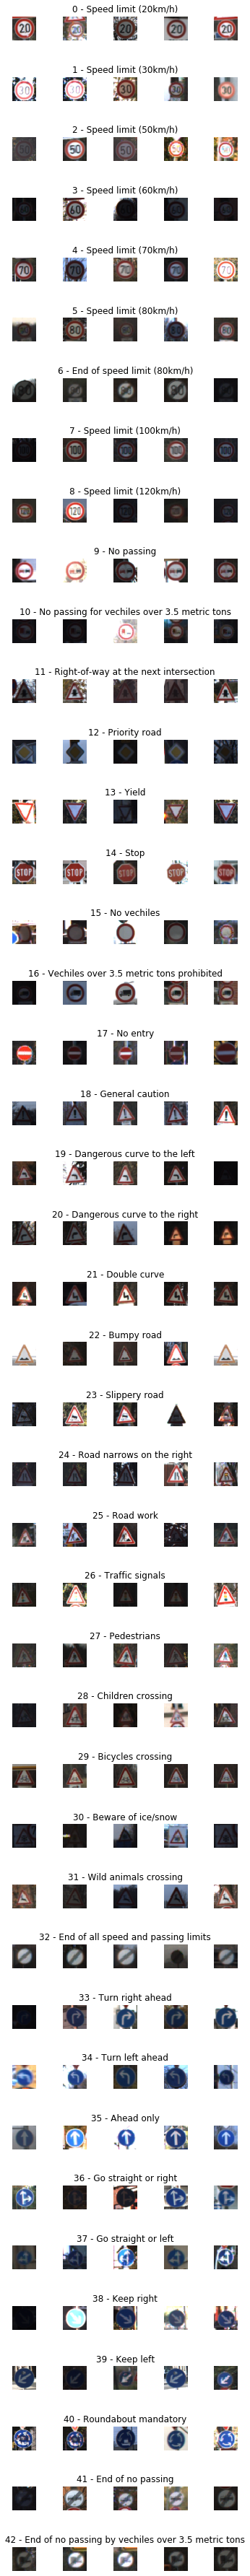

In [43]:
num_of_samples=[]

cols = 5
num_classes = 43
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()


for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))
            


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


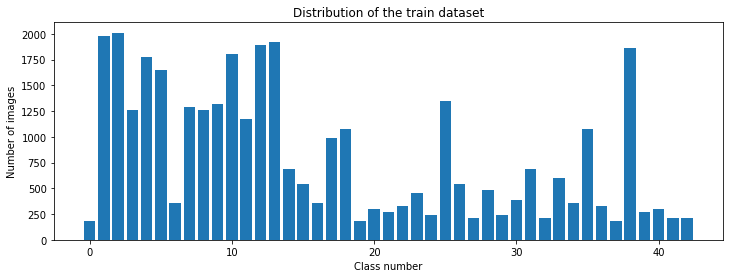

In [44]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36
(32, 32)
(32, 32)


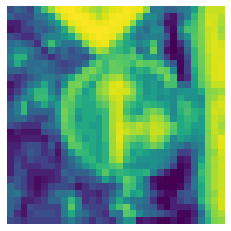

In [45]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)


Added a depth of 1


In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
    

(34799, 32, 32)


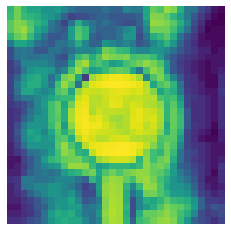

In [47]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
    
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10)
datagen.fit(X_train)


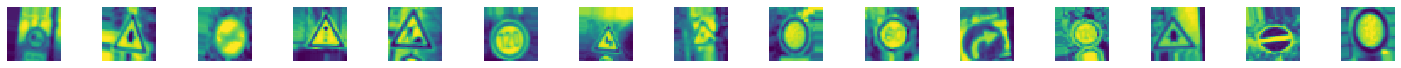

In [49]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32,32))
    axs[i].axis('off')

In [0]:

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

1.   Using : LENet Model - 1998 recognizes hand written letters in cheque book
2.   Other models we have are AlexNet, zfNet, GoogleNet


Modifications

1.   Changed lr = 0.001 from 0.01 - train- 97%, valid-92%
2.   Conv2D 60, 30 - Still overfitting - train-98%, valid-93%
3.   Added Conv2D60, Conv2D30
4.   Added extra dropout after MaxPooling - Validation accuracy is now higher than Training accuracy.



In [0]:
# Define leNet model
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2))) #Shrinks from 32x32x30 to 14x14x30
    
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2))) #Shrinks from 24x24x30 to 12x12x30
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [52]:
model = modified_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 30)         

In [53]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=400, verbose=1, shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 6s 170us/step - loss: 2.3222 - acc: 0.3708 - val_loss: 0.7278 - val_acc: 0.7941
Epoch 2/10
34799/34799 [==============================] - 5s 149us/step - loss: 0.7144 - acc: 0.7778 - val_loss: 0.3163 - val_acc: 0.9059
Epoch 3/10
34799/34799 [==============================] - 5s 149us/step - loss: 0.4142 - acc: 0.8710 - val_loss: 0.1904 - val_acc: 0.9426
Epoch 4/10
34799/34799 [==============================] - 5s 149us/step - loss: 0.3008 - acc: 0.9073 - val_loss: 0.1509 - val_acc: 0.9574
Epoch 5/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.2341 - acc: 0.9271 - val_loss: 0.1215 - val_acc: 0.9639
Epoch 6/10
34799/34799 [==============================] - 5s 147us/step - loss: 0.1917 - acc: 0.9385 - val_loss: 0.0866 - val_acc: 0.9741
Epoch 7/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.1620 - acc: 0.9474 - val_loss: 0.0947 - v

Text(0.5, 1.0, 'loss')

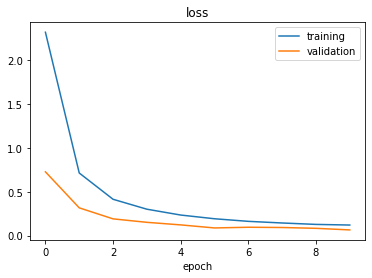

In [54]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

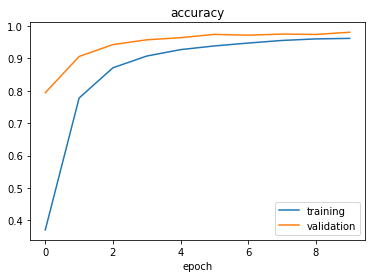

In [55]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.title('accuracy')

In [56]:
score = model.evaluate(X_test, y_test, verbose=0)
print(type(score))
print('Test score : ', score[0])
print('Test accuracy : ', score[1])

<class 'list'>
Test score :  0.13986638581154606
Test accuracy :  0.9603325415865731


https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg
Preditct sign: [1]
(1, 32, 32, 1)
https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg
Preditct sign: [12]
(1, 32, 32, 1)
https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg
Preditct sign: [23]
(1, 32, 32, 1)
https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg
Preditct sign: [12]
(1, 32, 32, 1)
https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg
Preditct sign: [31]
(1, 32, 32, 1)


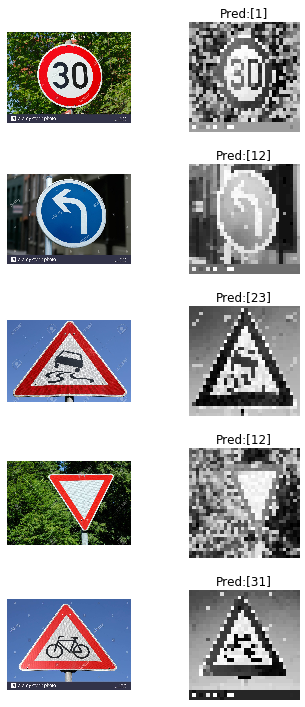

In [57]:
 # Testing modifed model to Predict
import requests
from PIL import Image

urls = ['https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg', 
        'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
        'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
        'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
        'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg']


fig, axs = plt.subplots(nrows=len(urls), ncols=2, figsize=(5,10))
fig.tight_layout()

for j in range(len(urls)):
    print(urls[j])
    r = requests.get(urls[j], stream=True)
    img = Image.open(r.raw)
    axs[j][0].imshow(img, cmap=plt.get_cmap('gray'))
    axs[j][0].axis('off')
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocess(img)
    axs[j][1].imshow(img, cmap = plt.get_cmap('gray'))
    axs[j][1].axis('off')
    img = img.reshape(1, 32, 32, 1)
    axs[j][1].set_title('Pred:'+ str(model.predict_classes(img)))
    print("Preditct sign: " + str(model.predict_classes(img)))
    print(img.shape)